## Policy gradient

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

Run a ChildNet architecture and obtain the reward

In [2]:
from childNet import ChildNet

layer_limit = 7 # max_layers

cn = ChildNet(layer_limit)
nb_epochs = 100

cn.compute_reward(['Tanh', 4, 1, 'ReLU', 8, 1], nb_epochs)

0.49000000953674316

Define the Policy Net and its loss (controller loss)

In [43]:
n_hidden = 24
possible_hidden_units = [1,2,4,8,16,32,'EOS']
encoded_eos = len(possible_hidden_units)
possible_act_functions = ['Sigmoid', 'Tanh', 'ReLU', 'LeakyReLU']
total_actions = possible_hidden_units + possible_act_functions
n_outputs = len(possible_hidden_units) + len(possible_act_functions)

batch_size = 15
learning_rate = 1e-2

class PolicyNet(nn.Module):
    """Policy network"""

    def __init__(self, n_hidden, n_outputs, learning_rate, layer_limit):
        super(PolicyNet, self).__init__()
        
        self.layer_limit = layer_limit
        self.gamma = 1.0
        
        self.lstm = nn.LSTMCell(n_outputs, n_hidden)
        #self.lstm2 = nn.LSTMCell(n_hidden, n_hidden)
        self.layer_hid_un = nn.Linear(n_hidden, len(possible_hidden_units))
        self.layer_act_func = nn.Linear(n_hidden, len(possible_act_functions))
        self.linear = nn.Linear(n_hidden, n_outputs)
        
        # training
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        
    def one_hot(self, t, num_classes):
        out = np.zeros((t.shape[0], num_classes))
        for row, col in enumerate(t):
            out[row, col] = 1
        return out.astype('float32')

    def sample_action(self, output, training):
        if training:
            random_array = np.random.rand(batch_size).reshape(batch_size,1)
            return (np.cumsum(output.detach().numpy(), axis=1) > random_array).argmax(axis=1) # sample action
        else: #eval
            return (output.detach().numpy()).argmax(axis=1)
                
    def forward(self, training):
        outputs = []
        prob = []
        actions = np.zeros((batch_size, self.layer_limit))
        action = not None #initialize action to don't break the while condition 
        i = 0
        counter_nb_layers = 0
        
        h_t = torch.zeros(batch_size, n_hidden, dtype=torch.float)
        c_t = torch.zeros(batch_size, n_hidden, dtype=torch.float)
        action = torch.zeros(batch_size, n_outputs, dtype=torch.float)

        #h_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)
        #c_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)
        
        while counter_nb_layers<self.layer_limit: 
            #得到输出和记忆
            h_t, c_t = self.lstm(action, (h_t, c_t))
            
            #h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            
            output = F.softmax(self.linear(h_t))
            counter_nb_layers += 1
            #选新的动作
            action = self.sample_action(output, training)

            outputs += [output]
            prob.append(output[np.arange(batch_size),action])
            print(np.arange(batch_size),action)
            actions[:, i] = action
            action = torch.tensor(self.one_hot(action, n_outputs))            
            i += 1
            
        prob = torch.stack(prob, 1)
        outputs = torch.stack(outputs, 1).squeeze(2)
        #outputs.view(-1, n_outputs)
        
        return prob, actions

    def loss(self, action_probabilities, returns, baseline):        
        #T is the number of hyperparameters 
        sum_over_T = torch.sum(torch.log(action_probabilities.view(batch_size, -1)), axis=1)
        subs_baseline = torch.add(returns,-baseline)
        return torch.mean(torch.mul(sum_over_T, subs_baseline)) - torch.sum(torch.mul (torch.tensor(0.01) * action_probabilities, torch.log(action_probabilities.view(batch_size, -1))))


In [44]:
np.random.rand(batch_size).reshape(batch_size,1)

array([[0.9654905 ],
       [0.99760011],
       [0.49836047],
       [0.96036651],
       [0.81597712],
       [0.75637147],
       [0.36595268],
       [0.85038562],
       [0.91911114],
       [0.73400281],
       [0.64648711],
       [0.6403994 ],
       [0.15568041],
       [0.21991088],
       [0.22894303]])

Helper functions

In [45]:
def indexes_to_actions(actions):
    batch_hid_units = []
    batch_act_functions = []
    batch_index_eos = []
    
    for b in range(batch_size):
        batch_actions = actions[b,:]                
        hid_units = [total_actions[int(action)] for i,action in enumerate(batch_actions)]
        
        #cut when 'EOS' is reached
        try:
            index_eos = hid_units.index('EOS')
            hid_units = hid_units[:index_eos + 1]
        except ValueError:
            hid_units = hid_units[:-1] + ['EOS']
            index_eos = len(hid_units)
    
        batch_hid_units.append(hid_units)
        batch_index_eos.append(index_eos)
        
    #返回具体结构的列表和EOS的下标
    return batch_hid_units, batch_index_eos
    
def fill_tensor(tensor_to_fill, size, ones=True):
    if len(tensor_to_fill.size()) >= 2: #dim >= 2
        tensor_to_fill = tensor_to_fill.view(-1)
    
    if ones:
        #fill with ones, useful if afterwards it will be applied log (log 1 = 0, log 0 = -inf)
        size_remaining = size - tensor_to_fill.size()[0]
        return torch.cat((tensor_to_fill, torch.ones(size_remaining)))
    else:        
        size_remaining = size - tensor_to_fill.size()[0]
        return torch.cat((tensor_to_fill, torch.zeros(size_remaining)))

Test Forward pass


In [46]:
policy = PolicyNet(n_hidden, n_outputs, learning_rate, layer_limit)
outputs, actions = policy(True)
outputs, actions, indexes_to_actions(actions)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] [ 1  5  0  3  9 10  9  3  5 10  6  2  7  7  0]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] [8 0 7 7 6 4 6 6 6 9 9 8 5 3 9]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] [ 9  9  9  4  6  6  7  8  6 10  2  4  0 10  8]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] [1 3 5 3 1 6 2 7 7 9 5 7 0 7 4]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] [ 9 10  3  9  1  5  7  9  2  5 10  8  4  5 10]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] [ 5  0  2  0  5 10  8  0 10  1  0  2  5  0  8]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] [ 0  2  6  4  5  7  3  2 10  3  5  9  7  6  7]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


(tensor([[0.0829, 0.0877, 0.0934, 0.0869, 0.0923, 0.0945, 0.0991],
         [0.0946, 0.0981, 0.0913, 0.0924, 0.1018, 0.1043, 0.0835],
         [0.0998, 0.0920, 0.0927, 0.0941, 0.0921, 0.0849, 0.0950],
         [0.0910, 0.0900, 0.0751, 0.0934, 0.0918, 0.1024, 0.0715],
         [0.0922, 0.0937, 0.0944, 0.0847, 0.0858, 0.0968, 0.0987],
         [0.1028, 0.0762, 0.0965, 0.0951, 0.0918, 0.1015, 0.0930],
         [0.0922, 0.0937, 0.0909, 0.0869, 0.0922, 0.0875, 0.0969],
         [0.0910, 0.0944, 0.0861, 0.0918, 0.0941, 0.1011, 0.0854],
         [0.0946, 0.0958, 0.0948, 0.0921, 0.0869, 0.1034, 0.1008],
         [0.1028, 0.0908, 0.0990, 0.0899, 0.0940, 0.0864, 0.0912],
         [0.0929, 0.0931, 0.0892, 0.0952, 0.1021, 0.1024, 0.0986],
         [0.0874, 0.0887, 0.0755, 0.0916, 0.0878, 0.0847, 0.0919],
         [0.0930, 0.0940, 0.0979, 0.0994, 0.0710, 0.0969, 0.0916],
         [0.0930, 0.0927, 0.1027, 0.0918, 0.0934, 0.0989, 0.0978],
         [0.0998, 0.0919, 0.0885, 0.0735, 0.0983, 0.0882, 0.09

In [7]:
print(policy)

PolicyNet(
  (lstm): LSTMCell(11, 24)
  (layer_hid_un): Linear(in_features=24, out_features=7, bias=True)
  (layer_act_func): Linear(in_features=24, out_features=4, bias=True)
  (linear): Linear(in_features=24, out_features=11, bias=True)
)


Train the policy

In [47]:
# training settings
torch.set_num_threads(8)
num_episodes = 500
decay = 0.9
verbose = False
# setup policy network

policy = PolicyNet(n_hidden, n_outputs, learning_rate, layer_limit)
baseline = torch.zeros(15, dtype=torch.float)

# train policy network

try:
    training_rewards, val_rewards, losses = [], [], []
    baseline = torch.zeros(15, dtype=torch.float)
    print('start training')
    for i in range(1):
        rollout, batch_r, batch_a_probs = [], [], []
        training = True
        with torch.no_grad():
            prob, actions = policy(training)
        batch_hid_units, batch_index_eos = indexes_to_actions(actions)
        for j in range(batch_size):
            # policy gradient update 
            if verbose:
                print(batch_hid_units[j])
            r = cn.compute_reward(batch_hid_units[j], nb_epochs)**3
            if batch_hid_units[j]==['EOS']:
                r -= -1
            a_probs = prob[j, :batch_index_eos[j] + 1]
            #print(a_probs,batch_index_eos[j])
            #print(batch_hid_units[j])
            batch_r += [r]
            print(a_probs.view(1, -1))
            batch_a_probs += [a_probs.view(1, -1)] 
        print(prob)
        print(batch_a_probs[1])
        a_probs = []
        for b in range(batch_size):
            a_probs.append(fill_tensor(batch_a_probs[b], n_outputs, ones=True))
        a_probs = torch.stack(a_probs,0)

        batch_a_probs = Variable(a_probs, requires_grad=True)
        batch_r = Variable(torch.tensor(batch_r), requires_grad=True)
        loss = policy.loss(batch_a_probs, batch_r, torch.mean(baseline))
        policy.optimizer.zero_grad()  
        loss.backward()
        policy.optimizer.step()
        
        # bookkeeping
        training_rewards.append(torch.mean(batch_r).detach().numpy())
        losses.append(loss.item())
        # actualize baseline
        baseline = torch.cat((baseline[1:]*decay, torch.tensor([torch.mean(batch_r)*(1-decay)], dtype=torch.float)))
        # print
        if verbose and (i+1) % val_freq == 0:
            print('{:4d}. mean training reward: {:6.2f}, mean loss: {:7.4f}'.format(i+1, np.mean(training_rewards[-val_freq:]), np.mean(losses[-val_freq:])))
        if i % 10 == 0:
            print(i)
        
    print('done')
except KeyboardInterrupt:
    print('interrupt')    

start training
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] [ 8  5  0  7  1  9  1 10  7  2  2  9  2  4  4]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] [ 1  8  1  9  5  6  9  3 10  6  1  2  5  7  1]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] [4 1 1 8 6 4 0 0 8 0 8 8 5 3 9]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] [ 1  9  8  7 10 10  8  2  7  4  1  9  3 10  8]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] [ 8  9  4  0 10 10  4  9  5 10  4  9  0  3  6]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] [ 9  0  0  8  6  1  5  2  8  8  4 10  7  2  0]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] [7 6 3 8 0 9 1 0 9 6 1 6 9 6 8]
tensor([[0.1024, 0.1019, 0.0867, 0.1062, 0.1016, 0.0849, 0.0756]])
tensor([[0.0735, 0.1032, 0.1011, 0.0856, 0.0821, 0.1049, 0.0943]])
tensor([[0.1061, 0.0988, 0.1017, 0.1036, 0.0868, 0.1040, 0.0842]])
tensor([[0.0757, 0.0871, 0.1048, 0.0743, 0.1029, 0.1091, 0.1105]])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[0.1009, 0.0701, 0.0922]])
tensor([[0.0849, 0.0937]])
tensor([[0.1009, 0.0861, 0.1055, 0.1081, 0.0881, 0.0701, 0.1003]])
tensor([[0.0963, 0.0849, 0.1053, 0.0948, 0.0870, 0.0986, 0.1055]])
tensor([[0.0757, 0.0958, 0.1063, 0.0748, 0.0713, 0.1047, 0.0851]])
tensor([[0.0980, 0.0917]])
tensor([[0.0980, 0.0991, 0.1033, 0.1022, 0.0867, 0.0857, 0.1077]])
tensor([[0.0849, 0.0999, 0.1060, 0.0849, 0.0819, 0.0990, 0.0939]])
tensor([[0.0980, 0.0706, 0.0710, 0.0869, 0.1056, 0.0749, 0.0873]])
tensor([[0.0856, 0.0747, 0.0852, 0.1007, 0.0861, 0.0941, 0.0914]])
tensor([[0.0856, 0.1051, 0.0861, 0.1038, 0.0956]])
tensor([[0.1024, 0.1019, 0.0867, 0.1062, 0.1016, 0.0849, 0.0756],
        [0.0735, 0.1032, 0.1011, 0.0856, 0.0821, 0.1049, 0.0943],
        [0.1061, 0.0988, 0.1017, 0.1036, 0.0868, 0.1040, 0.0842],
        [0.0757, 0.0871, 0.1048, 0.0743, 0.1029, 0.1091, 0.1105],
        [0.1009, 0.0701, 0.0922, 0.0970, 0.0964, 0.0934, 0.1045],
        [0.0849, 0.0937, 0.0901, 0.0991, 0.0973, 0.0994, 0.08

Plot the training losses and the training rewards

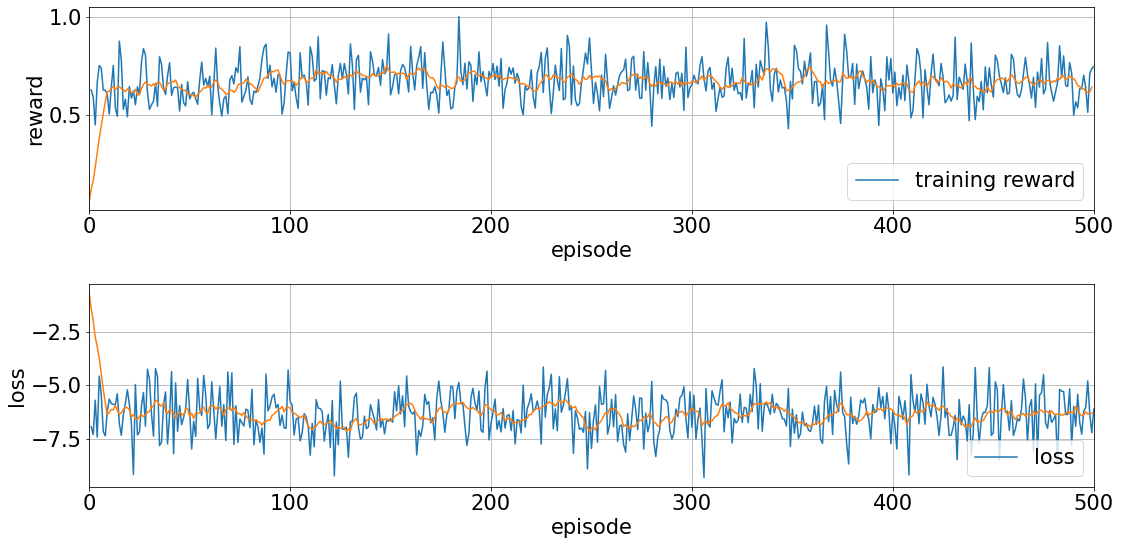

In [8]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 21})

# plot results
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16,8))
plt.subplot(211)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()
plt.subplot(212)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))#, plt.ylim((-20,20))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); #plt.show()
plt.savefig('training.jpg')

Generate a childNet architecture and compute its reward

In [48]:
batch_hid_units, batch_index_eos = indexes_to_actions(policy(training)[1])
batch_hid_units, batch_index_eos

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] [ 9 10  1  8  9 10  9  7  2  3  8  4  9  4  7]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] [10  2  2  4  8  9  8  3  0  1  1  7  6  1  4]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] [ 5  8  6  3 10  5  9  4  0  6  8  2  7  4  3]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] [ 0  3  8  8  9  8  8  9  9  2  7 10  1  8 10]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] [ 7  3  7 10 10  9  6  6 10  7  0  2  4  5  3]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] [ 2  8  1  0  4  8  8  2  2 10  0  0  0  3  8]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] [ 9 10  2  4  0  6  0  4 10  1  2  2  9  9 10]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


([['ReLU', 'LeakyReLU', 32, 1, 'Sigmoid', 4, 'EOS'],
  ['LeakyReLU', 4, 'Tanh', 8, 8, 'Tanh', 'EOS'],
  [2, 4, 'EOS'],
  ['Tanh', 16, 8, 'Tanh', 'LeakyReLU', 1, 'EOS'],
  ['ReLU', 'Tanh', 'LeakyReLU', 'ReLU', 'LeakyReLU', 16, 'EOS'],
  ['LeakyReLU', 'ReLU', 32, 'Tanh', 'ReLU', 'Tanh', 'EOS'],
  ['ReLU', 'Tanh', 'ReLU', 'Tanh', 'EOS'],
  ['Sigmoid', 8, 16, 'ReLU', 'EOS'],
  [4, 1, 1, 'ReLU', 'LeakyReLU', 4, 'EOS'],
  [8, 2, 'EOS'],
  ['Tanh', 2, 'Tanh', 'Sigmoid', 1, 1, 'EOS'],
  [16, 'Sigmoid', 4, 'LeakyReLU', 4, 1, 'EOS'],
  ['ReLU', 'EOS'],
  [16, 2, 16, 'Tanh', 32, 8, 'EOS'],
  ['Sigmoid', 16, 8, 'LeakyReLU', 8, 'Tanh', 'EOS']],
 [7, 7, 2, 7, 7, 6, 4, 4, 7, 2, 7, 7, 1, 7, 7])

In [10]:
cn.compute_reward([8, 'ReLU', 4, 'Tanh', 4, 'ReLU', 'EOS'], nb_epochs)

0.9599999785423279

In [12]:
cn.compute_reward(['LeakyReLU', 'ReLU', 'Sigmoid', 'EOS'],nb_epochs)

0.7200000286102295

In [13]:
cn.compute_reward(['LeakyReLU', 8, 'Tanh', 32, 'EOS'], nb_epochs)

0.8600000143051147

In [14]:
torch.save(policy.state_dict(), 'policy.pt')